In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
#import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)
import feature_analysis as fa
import porto_seguro as ps

import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [3]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

In [4]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[2:]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])

binaries = train[binary_fs]
categoricals = ps.fuseCategoricalFeatures(train[categorical_fs])
cont_ordinals = train[other_fs]
target = train.target

train.shape, binaries.shape, categoricals.shape, cont_ordinals.shape

((595212, 59), (595212, 17), (595212, 14), (595212, 26))

In [5]:
all_fs

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [6]:
if False:
    converted_cont = ps.convertOrdinalFeatures(cont_ordinals, target, verbose=False)

    new_categoricals = ps.fuseCategoricalFeatures(categoricals)

    bincats = pd.concat([binaries, new_categoricals], axis=1)
    bincat2probas = {}
    for i, f in enumerate(bincats.columns):
        fvt = fa.FeatureVsTarget(bincats[f], target)
        bincat2probas[f] = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()

    bincat_converted = pd.DataFrame()
    for i, f in enumerate(bincats.columns):
        bincat_converted[f] = bincats[f].replace(bincat2probas[f])

    converted = pd.concat([bincat_converted, converted_cont], axis=1)

In [7]:
if False:
    converted2 = (converted/100) + 1

In [8]:
if False:
    converted2.to_csv('./data/cond_proba_space.csv', index=False)

In [9]:
if True:
    converted2 = pd.read_csv('./data/cond_proba_space.csv')

In [10]:
converted2.head(5)

,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_car_13,ps_car_14,ps_car_15,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02,ps_reg_03
0,1.000942,1.002469,0.999215,0.998197,1.006565,0.987045,1.140953,1.299123,0.970069,1.020198,...,1.046285,0.937280,1.141674,1.007003,1.049128,0.995984,0.860137,1.056189,0.825299,0.954400
1,1.000942,1.002469,0.999215,0.998197,0.987755,1.002346,1.140953,0.896517,1.152664,1.020198,...,0.803583,0.942272,0.815322,0.924580,1.133283,0.995984,1.083735,1.064549,0.986359,0.983678
2,1.000942,1.002469,0.999215,0.998197,0.987755,1.002346,1.140953,0.896517,1.152664,1.020198,...,0.821368,0.948083,1.068257,1.111436,0.995839,0.995984,0.841713,1.042805,0.885852,0.779018
3,1.000942,0.995834,1.000975,0.998197,1.006565,1.002346,0.782969,0.896517,0.970069,1.020198,...,0.751776,1.007688,0.737108,0.911950,0.843828,0.995984,0.989755,1.127504,0.825299,0.890997
4,1.000942,0.995834,1.000975,1.004475,0.987755,1.002346,0.782969,0.896517,0.970069,1.020198,...,0.768783,0.937597,0.737108,0.911950,1.460846,0.995984,0.886947,1.056189,1.149334,1.034074


In [11]:
ind_fs = [f for f in all_fs if 'ind' in f]
car_fs = [f for f in all_fs if 'car' in f]
calc_fs = [f for f in all_fs if 'calc' in f]
reg_fs = [f for f in all_fs if 'reg' in f]

In [12]:
len(ind_fs), len(car_fs), len(calc_fs), len(reg_fs), len(all_fs)

(18, 16, 20, 3, 57)

In [13]:
inds = converted2[ind_fs]
cars = converted2[car_fs]
calcs = converted2[calc_fs]
regs = converted2[reg_fs]

In [14]:
y = np.array(target)

# Scaling

In [15]:
scaler = StandardScaler()
inds = scaler.fit_transform(converted2[ind_fs])
cars = scaler.fit_transform(converted2[car_fs])
calcs = scaler.fit_transform(converted2[calc_fs])
regs = scaler.fit_transform(converted2[reg_fs])

### inds

In [16]:
inds.shape

(595212, 18)

In [17]:
pca1 = PCA()
X1 = np.array(inds)
Xpca1 = pca1.fit_transform(X1)

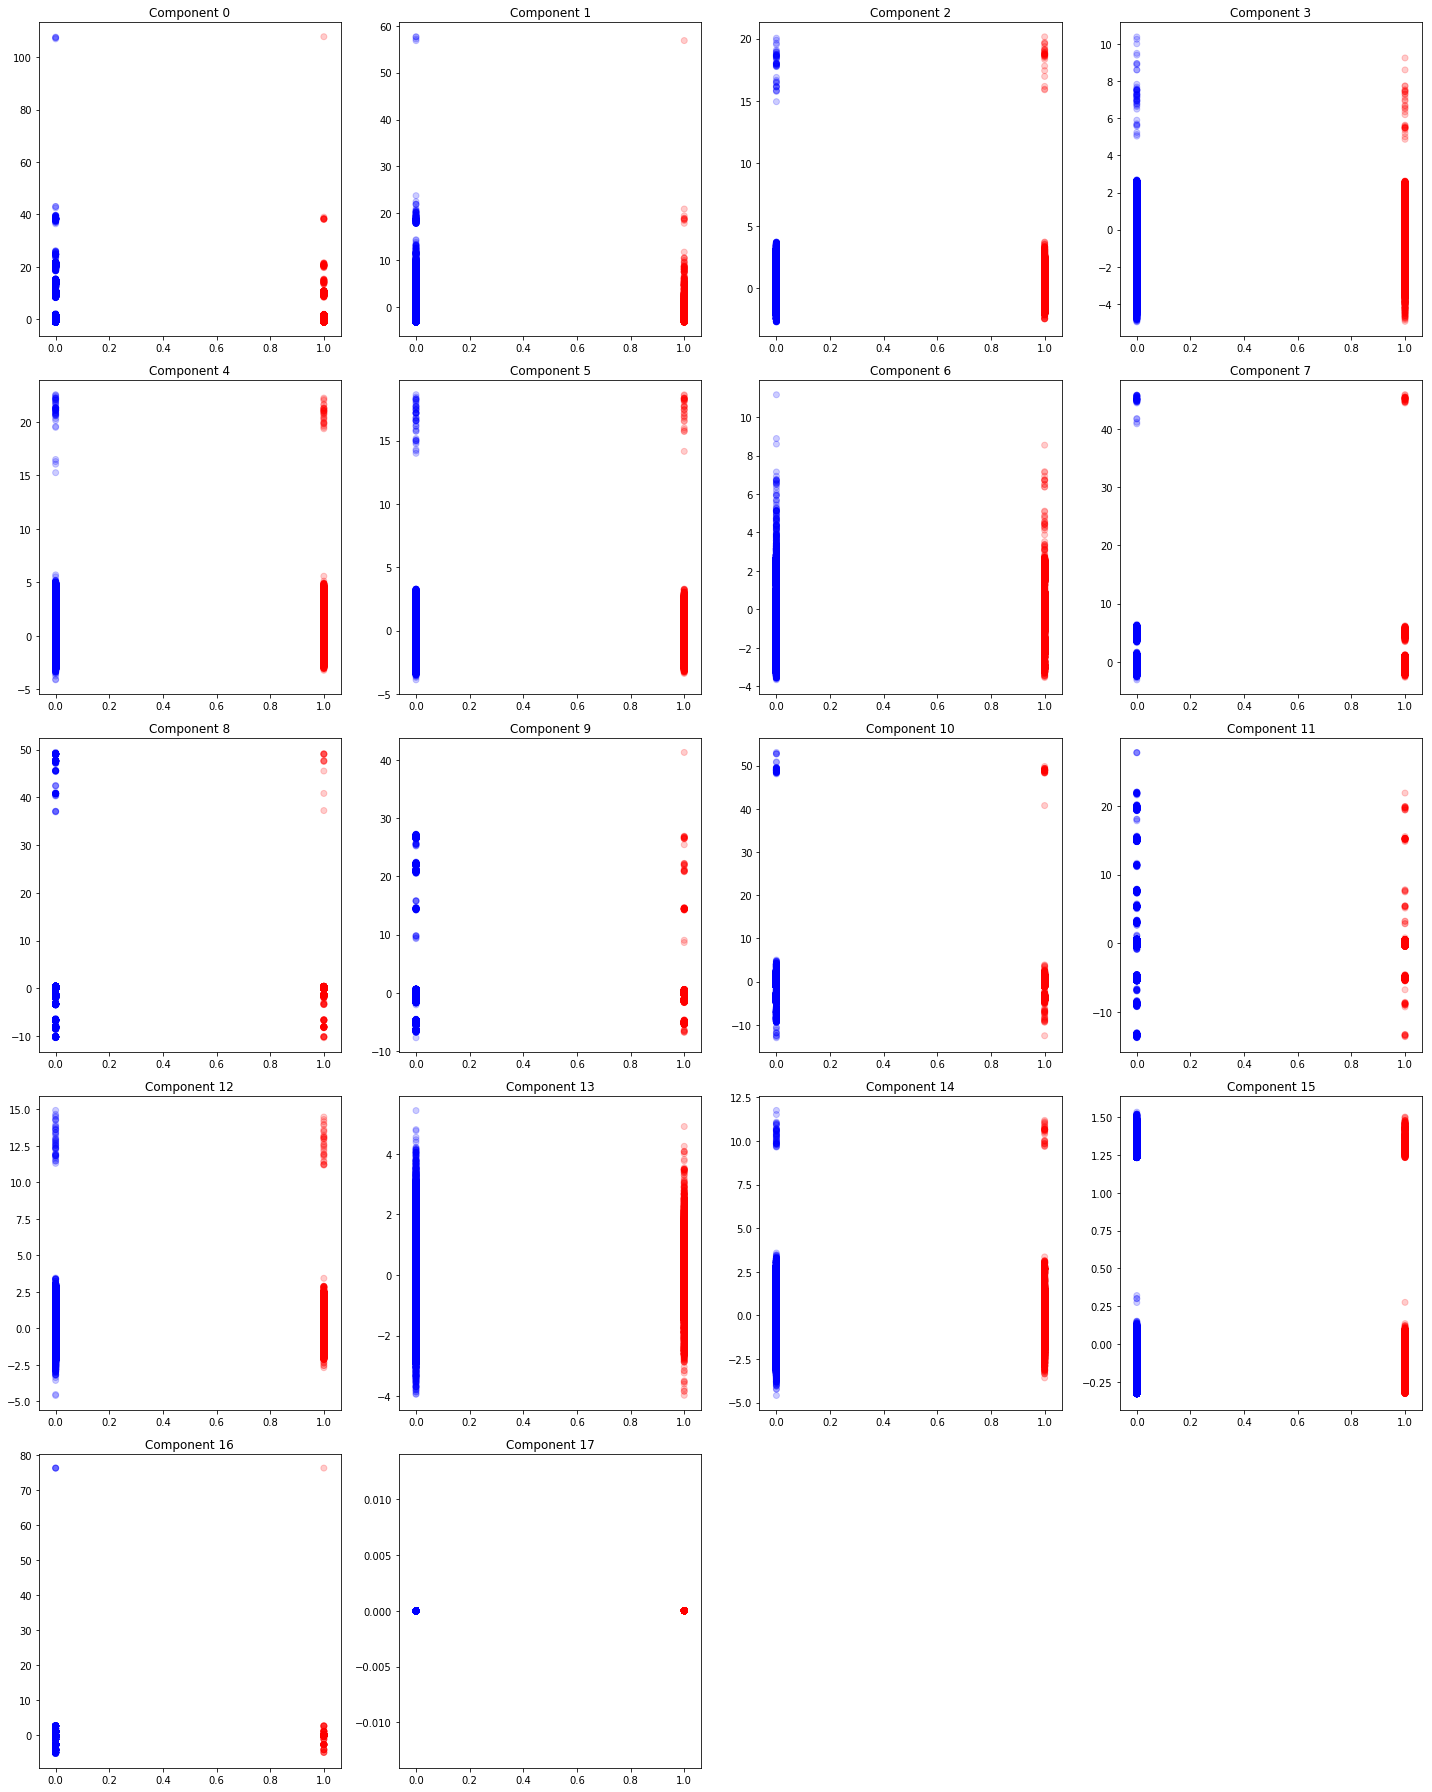

In [18]:
fig = plt.figure(figsize=(20, 25))
for i in range(inds.shape[1]):
    ax = fig.add_subplot(5, 4, i+1)
    ax.scatter(y, Xpca1[:, i], c=y, cmap=cm.bwr, alpha=0.2)
    ax.set_title('Component %d' % i)
plt.tight_layout()

### cars

In [19]:
cars.shape

(595212, 16)

In [20]:
pca2 = PCA()
X2 = np.array(cars)
Xpca2 = pca2.fit_transform(X2)

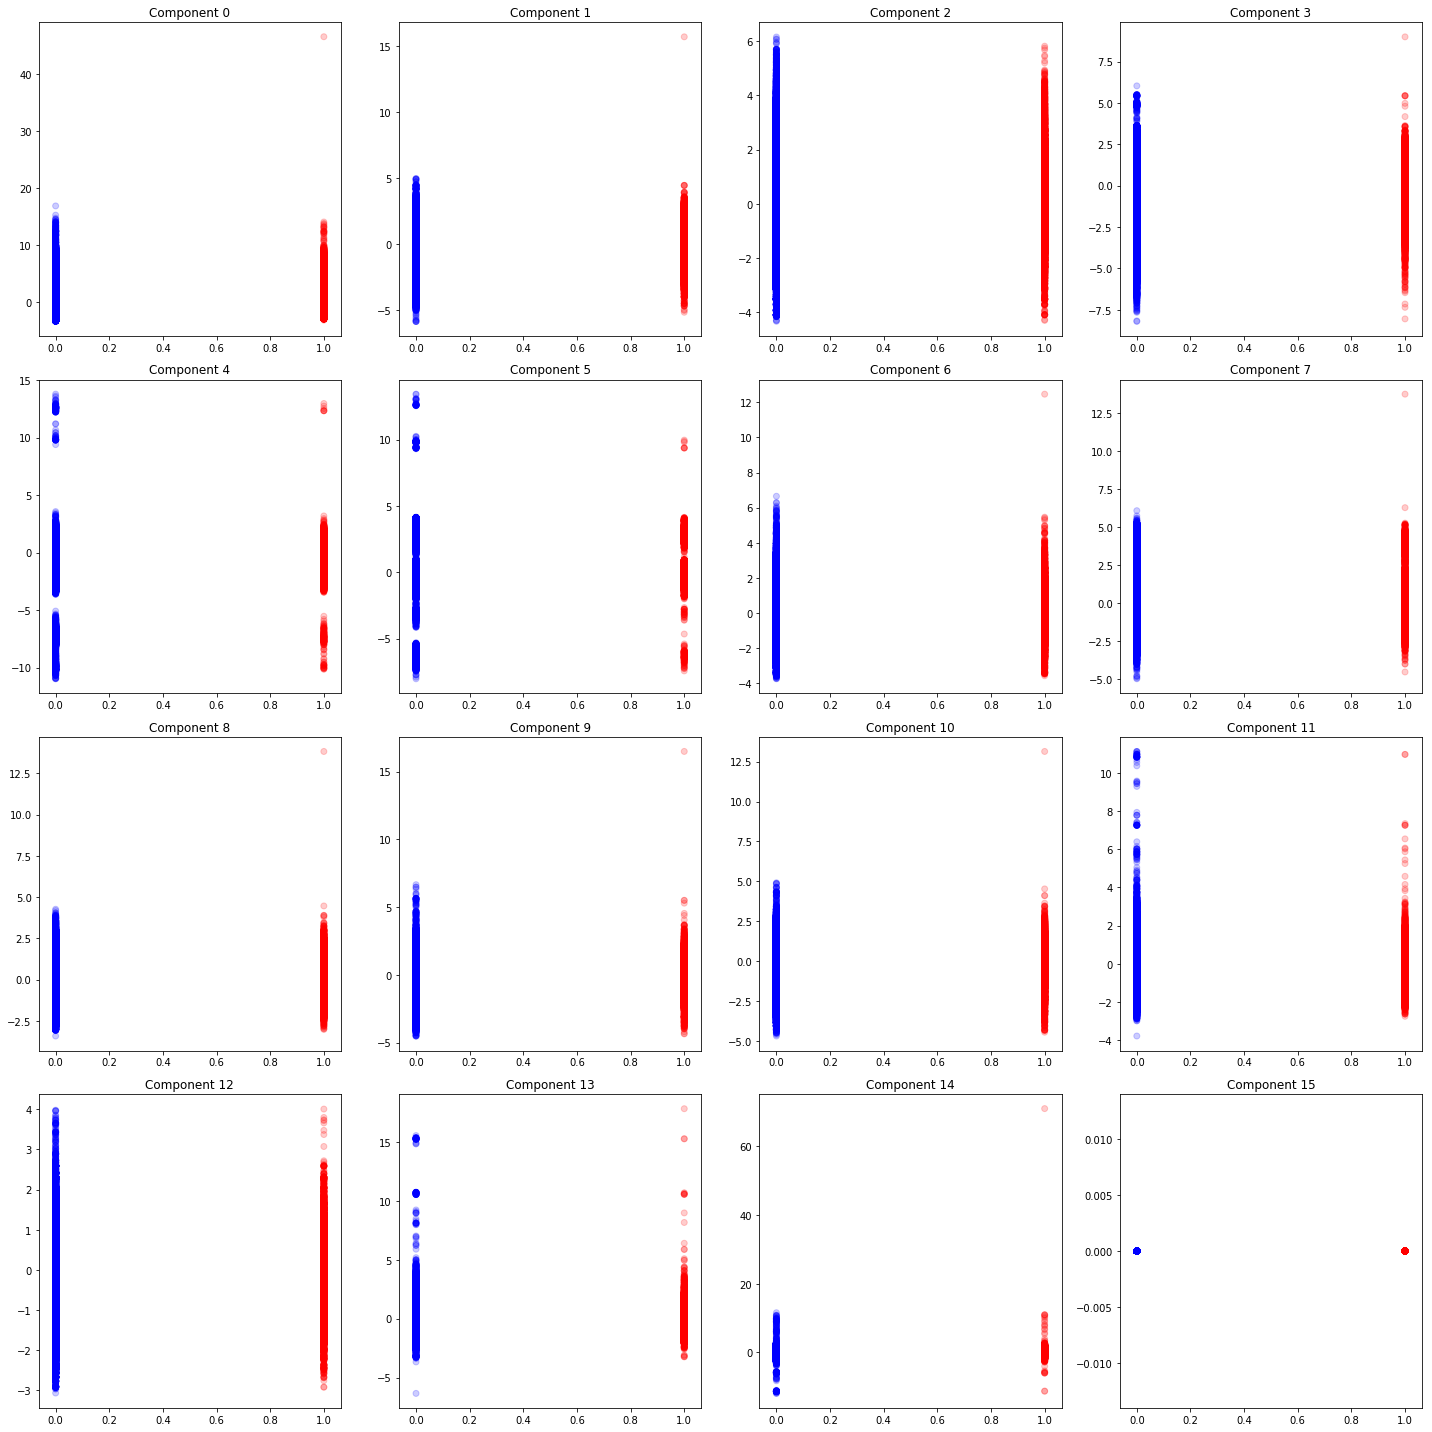

In [21]:
fig = plt.figure(figsize=(20, 20))
for i in range(cars.shape[1]):
    ax = fig.add_subplot(4, 4, i+1)
    ax.scatter(y, Xpca2[:, i], c=y, cmap=cm.bwr, alpha=0.2)
    ax.set_title('Component %d' % i)
plt.tight_layout()

### calcs

In [22]:
calcs.shape

(595212, 20)

In [23]:
pca3 = PCA()
X3 = np.array(calcs)
Xpca3 = pca3.fit_transform(X3)

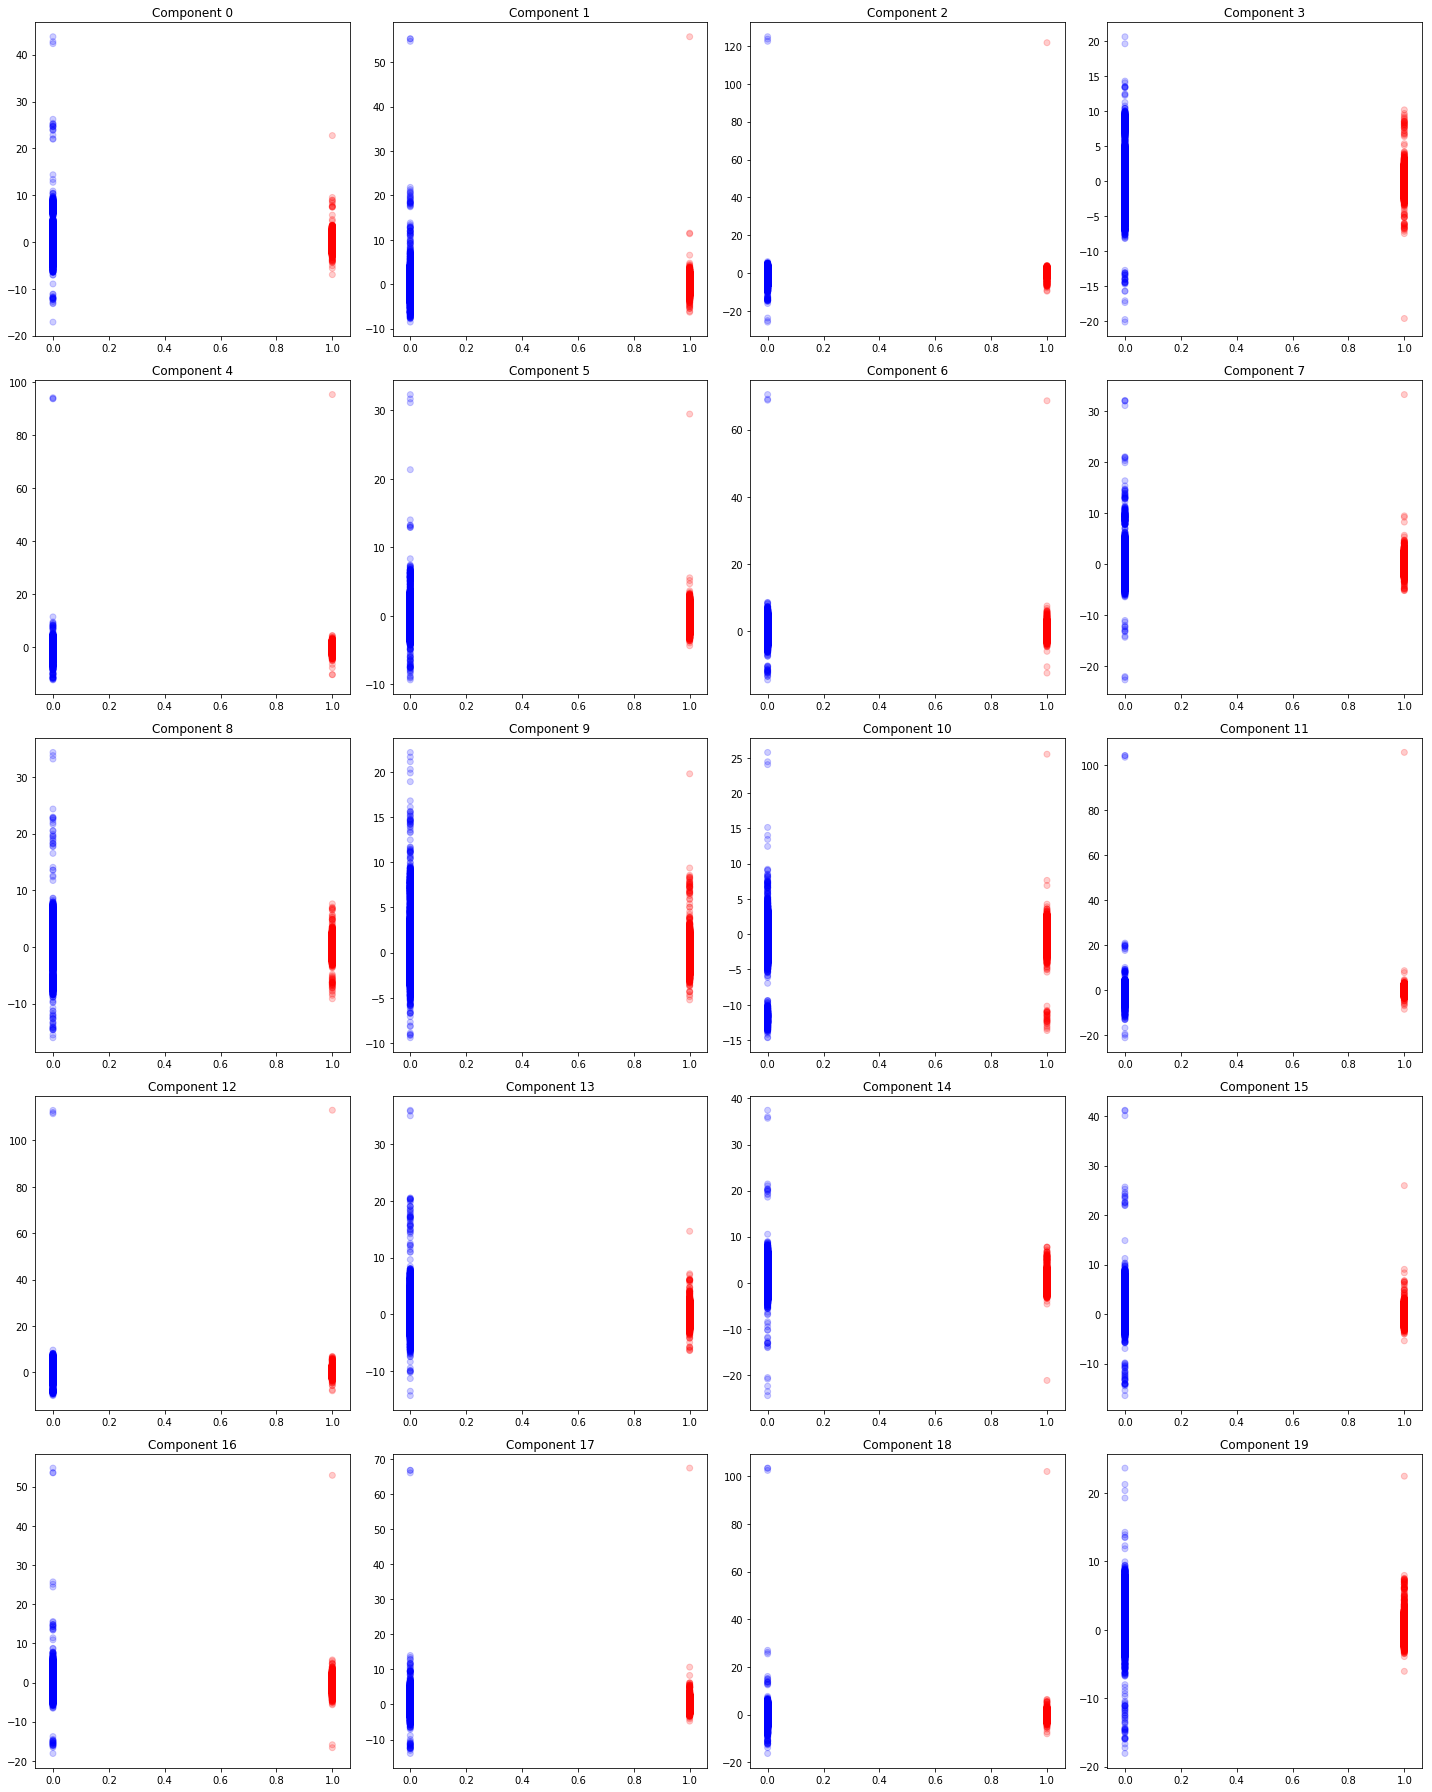

In [24]:
fig = plt.figure(figsize=(20, 25))
for i in range(calcs.shape[1]):
    ax = fig.add_subplot(5, 4, i+1)
    ax.scatter(y, Xpca3[:, i], c=y, cmap=cm.bwr, alpha=0.2)
    ax.set_title('Component %d' % i)
plt.tight_layout()

### regs

In [25]:
regs.shape

(595212, 3)

In [26]:
pca4 = PCA()
X4 = np.array(regs)
Xpca4 = pca4.fit_transform(X4)

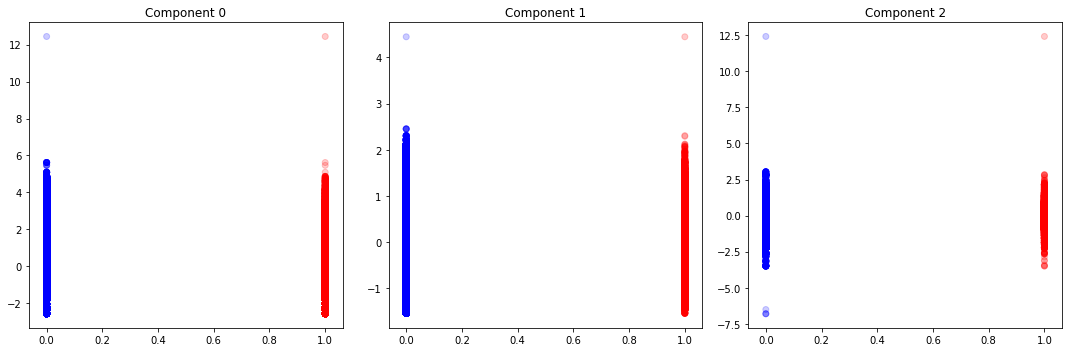

In [27]:
fig = plt.figure(figsize=(15, 5))
for i in range(regs.shape[1]):
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(y, Xpca4[:, i], c=y, cmap=cm.bwr, alpha=0.2)
    ax.set_title('Component %d' % i)
plt.tight_layout()

# No scaling

### inds

In [37]:
inds.shape

(595212, 18)

In [38]:
pca1 = PCA()
X1 = np.array(inds)
Xpca1 = pca1.fit_transform(X1)

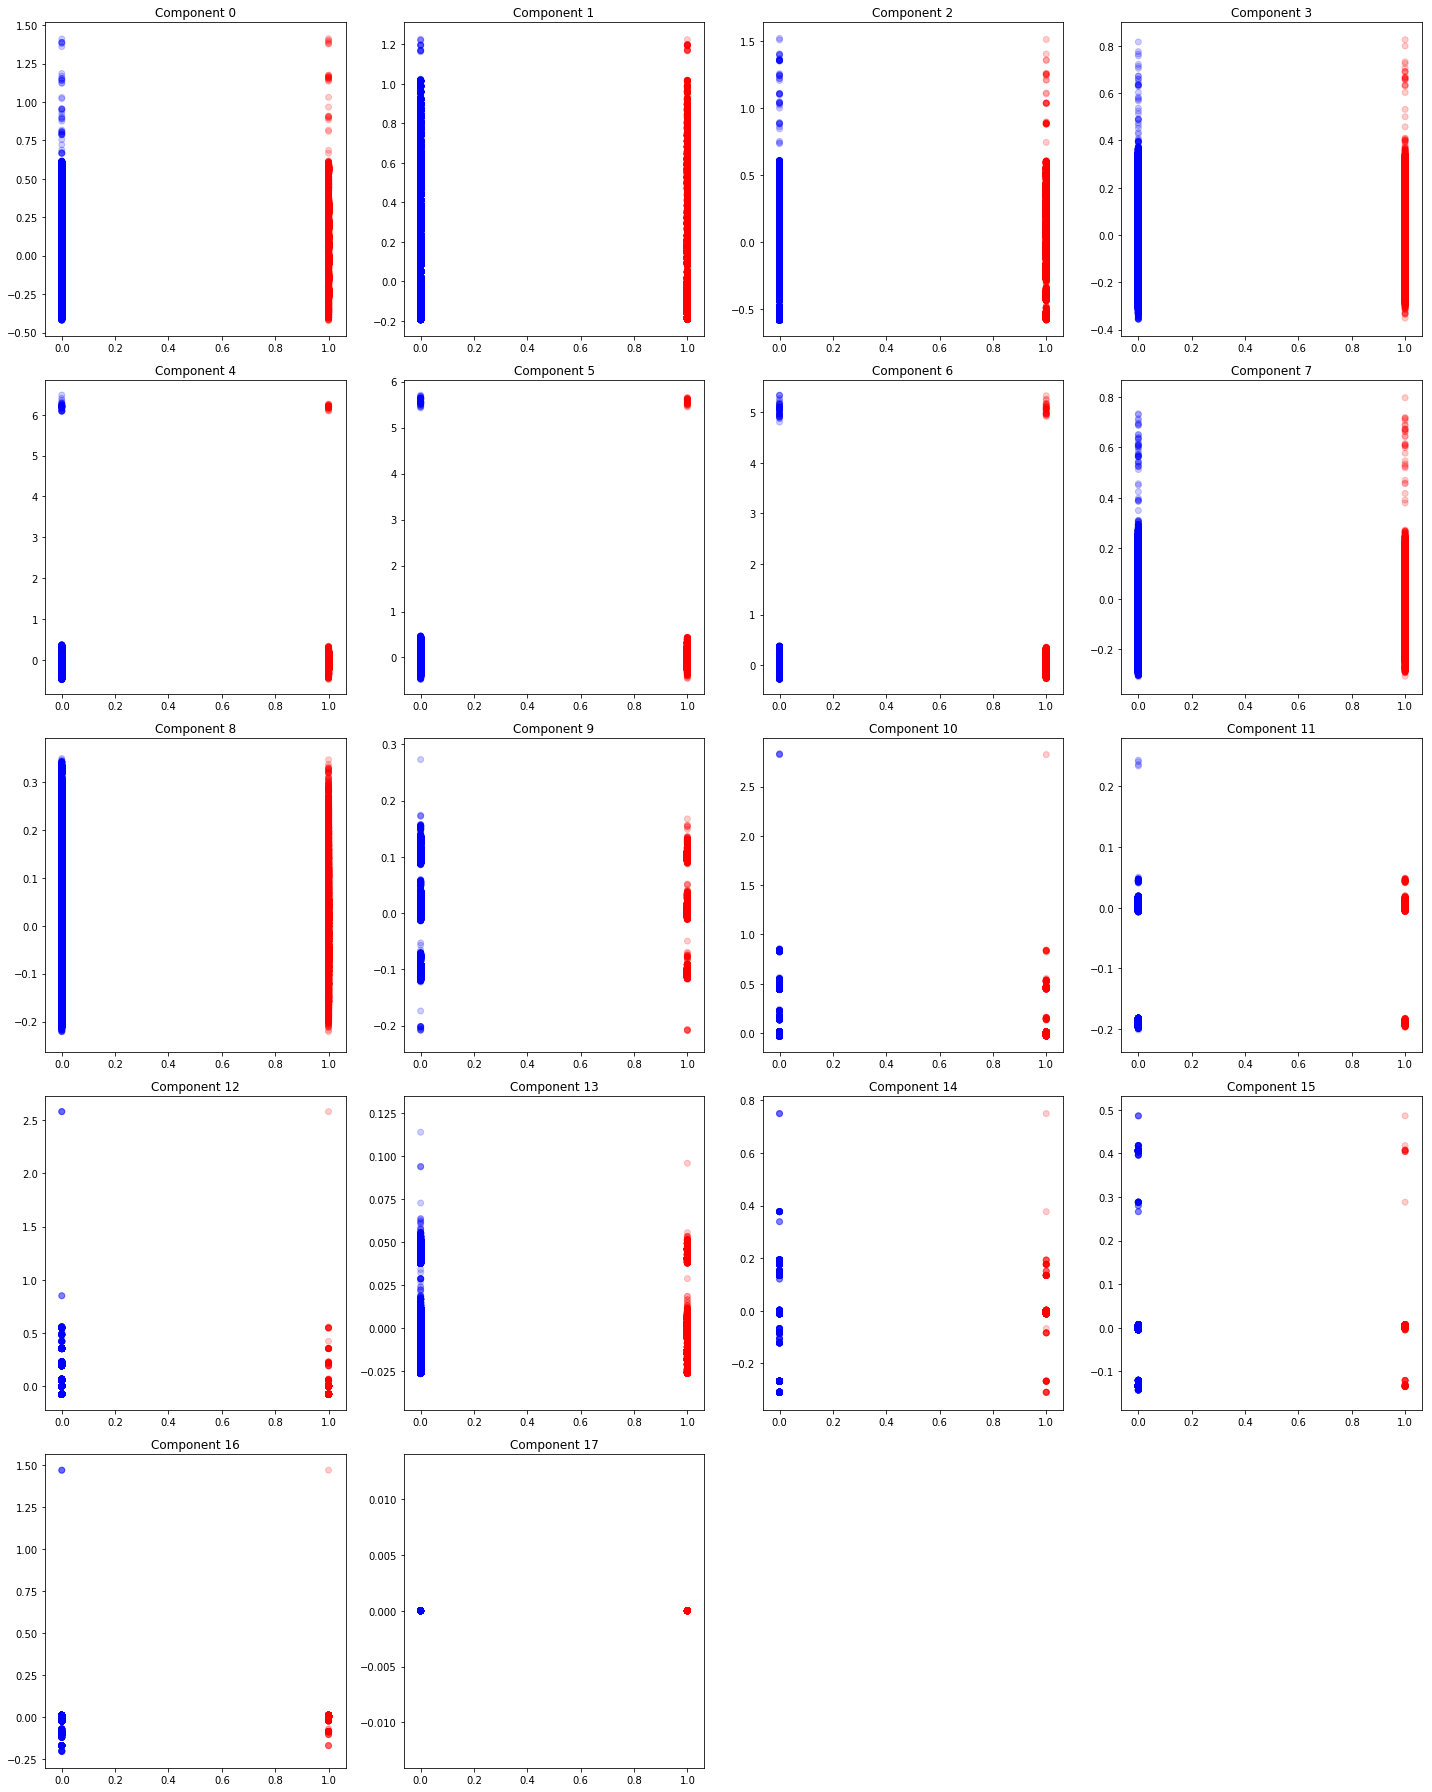

In [40]:
fig = plt.figure(figsize=(20, 25))
for i in range(inds.shape[1]):
    ax = fig.add_subplot(5, 4, i+1)
    ax.scatter(y, Xpca1[:, i], c=y, cmap=cm.bwr, alpha=0.2)
    ax.set_title('Component %d' % i)
plt.tight_layout()

### cars

In [41]:
cars.shape

(595212, 16)

In [42]:
pca2 = PCA()
X2 = np.array(cars)
Xpca2 = pca2.fit_transform(X2)

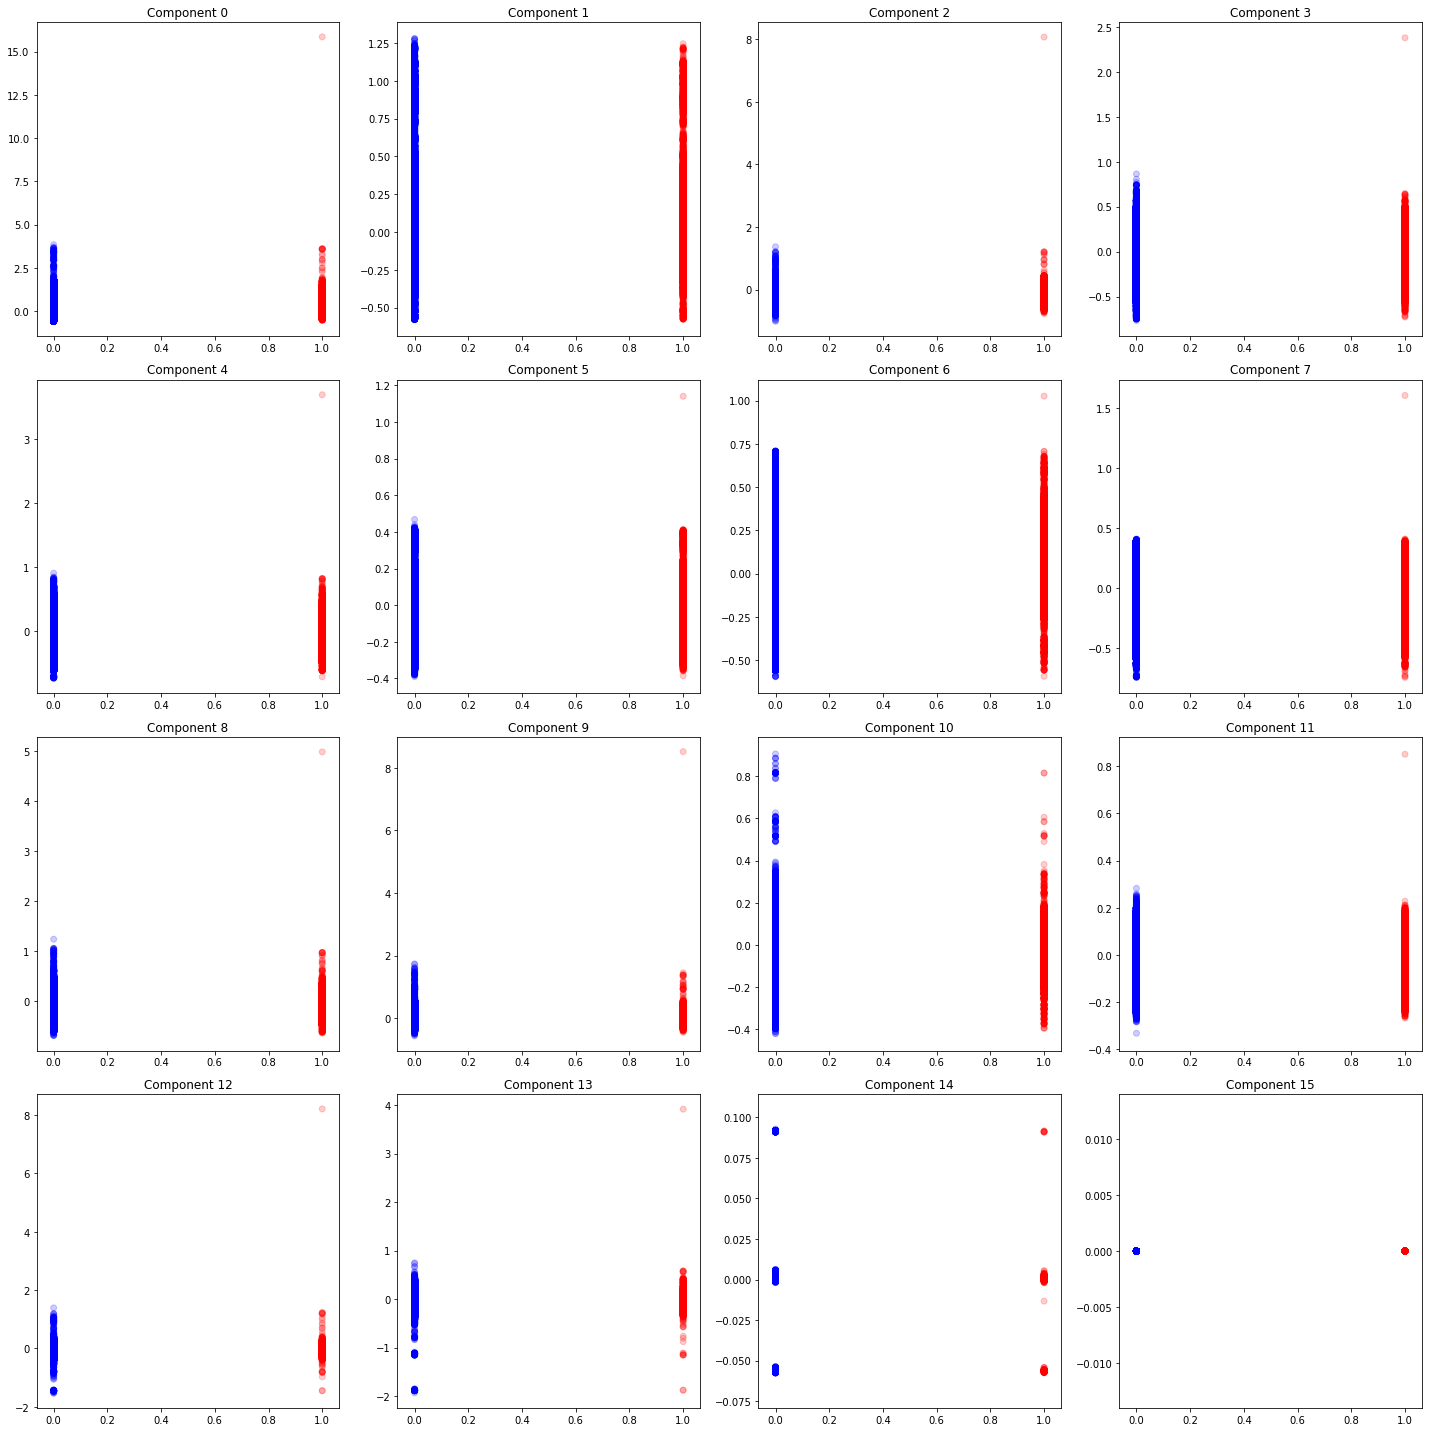

In [43]:
fig = plt.figure(figsize=(20, 20))
for i in range(cars.shape[1]):
    ax = fig.add_subplot(4, 4, i+1)
    ax.scatter(y, Xpca2[:, i], c=y, cmap=cm.bwr, alpha=0.2)
    ax.set_title('Component %d' % i)
plt.tight_layout()

### calcs

In [44]:
calcs.shape

(595212, 20)

In [45]:
pca3 = PCA()
X3 = np.array(calcs)
Xpca3 = pca3.fit_transform(X3)

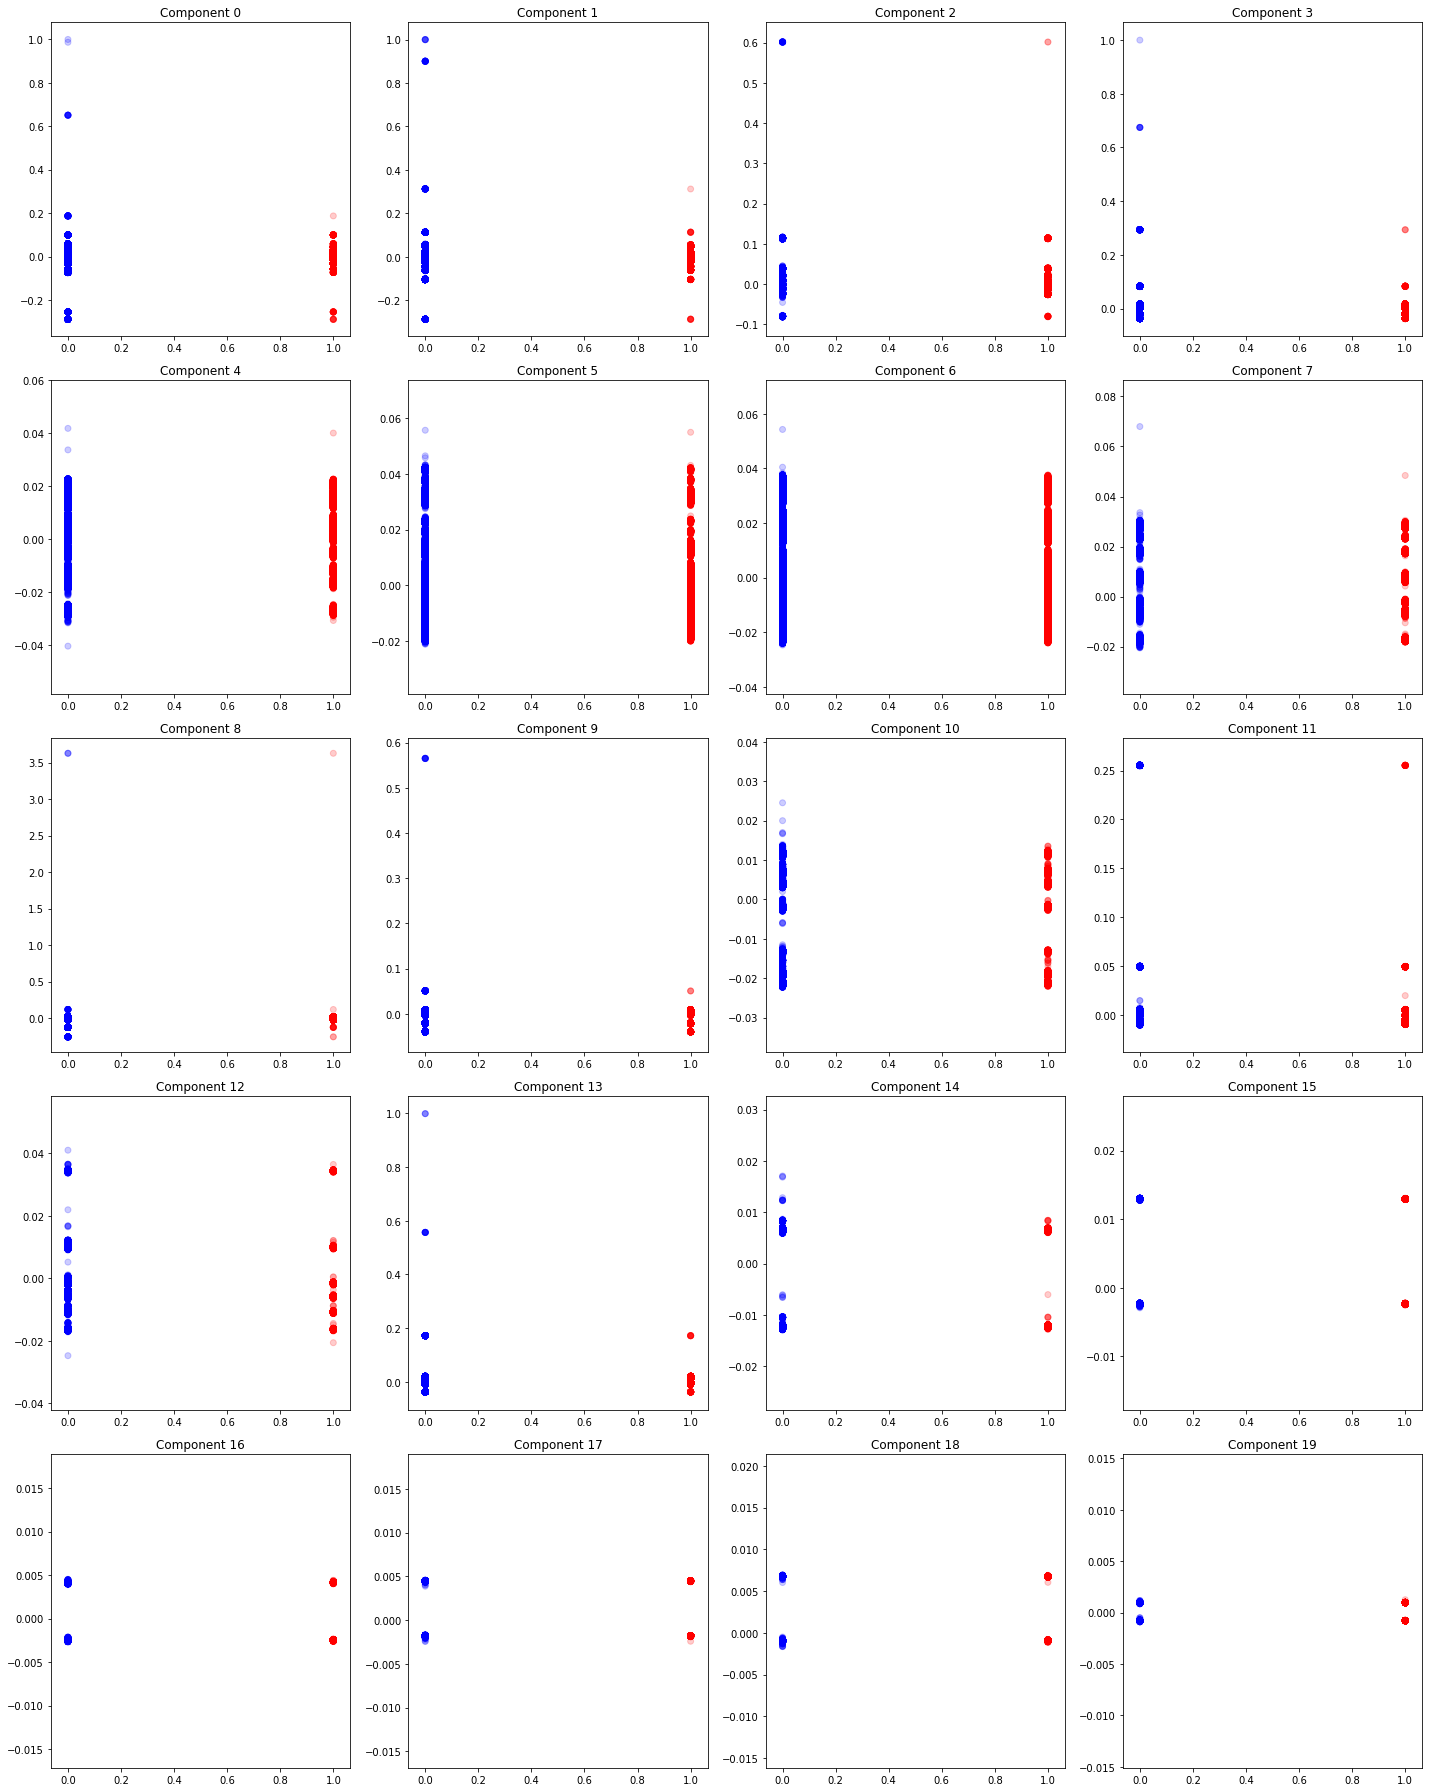

In [46]:
fig = plt.figure(figsize=(20, 25))
for i in range(calcs.shape[1]):
    ax = fig.add_subplot(5, 4, i+1)
    ax.scatter(y, Xpca3[:, i], c=y, cmap=cm.bwr, alpha=0.2)
    ax.set_title('Component %d' % i)
plt.tight_layout()

### regs

In [47]:
regs.shape

(595212, 3)

In [48]:
pca4 = PCA()
X4 = np.array(regs)
Xpca4 = pca4.fit_transform(X4)

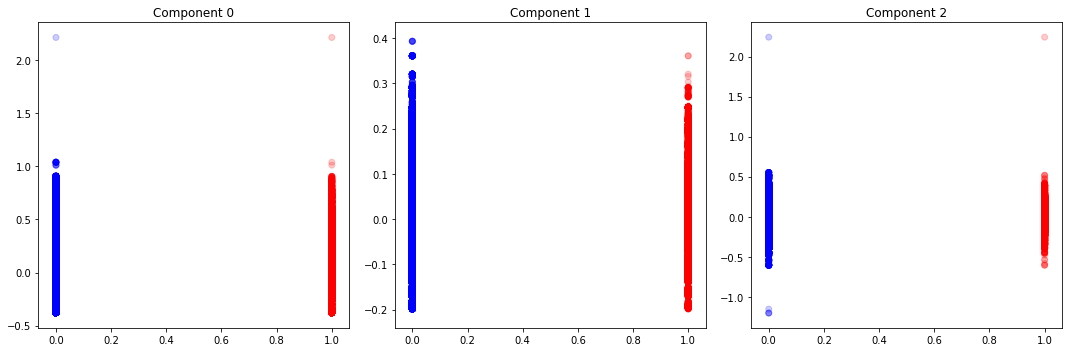

In [49]:
fig = plt.figure(figsize=(15, 5))
for i in range(regs.shape[1]):
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(y, Xpca4[:, i], c=y, cmap=cm.bwr, alpha=0.2)
    ax.set_title('Component %d' % i)
plt.tight_layout()

In [28]:
from sklearn.neural_network import MLPClassifier

In [30]:
X = np.concatenate((X1, X2, X3, X4), axis=1)

Gini=0.121+/-0.000, Best=0.121
CPU times: user 3min 9s, sys: 3min 35s, total: 6min 45s
Wall time: 51.7 s


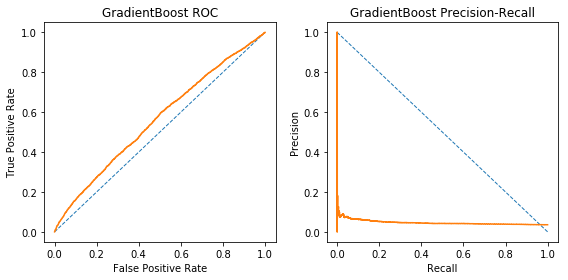

In [32]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(1):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = MLPClassifier(hidden_layer_sizes=(200,))
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))